In [1]:
import random

import numpy as np
import simpy


RANDOM_SEED = 1337


def queue_size(resource):
    return resource.count + len(resource.queue)


class RequestSimulator(object):
    def __init__(
            self, worker_desc, load_balancer,
            number_of_requests, request_per_s, avg_response_time_ms
        ):
        self.worker_desc = worker_desc
        self.load_balancer = load_balancer
        self.number_of_requests = number_of_requests
        self.request_interval_ms = 1. / (request_per_s / 1000.)
        self.avg_response_time_ms = avg_response_time_ms
        self.data = []

    def simulate(self):
        # Setup and start the simulation
        random.seed(RANDOM_SEED)
        np.random.seed(RANDOM_SEED)

        self.env = simpy.Environment()
        count, cap = self.worker_desc
        self.workers = [
            simpy.Resource(self.env, capacity=cap) for i in range(count)
        ]
        self.env.process(self.generate_requests())
        self.env.run()

    def generate_requests(self):
        for i in range(self.number_of_requests):
            idx = self.load_balancer(i, self.workers)
            worker = self.workers[idx]
            response = self.process_web_request(
                'Request%02d' % i, worker,
            )
            self.env.process(response)
            arrival_interval = random.expovariate(
                1.0 / self.request_interval_ms
            )
            yield self.env.timeout(arrival_interval)

    def process_web_request(self, name, worker):
        """ Request arrives, possibly queues, and then processes"""
        t_arrive = self.env.now

        with worker.request() as req:
            yield req
                        
            t_start = self.env.now
            t_queued = t_start - t_arrive

            request_duration = (
                np.random.pareto(2, 1) + self.avg_response_time_ms
            )[0]
            yield self.env.timeout(request_duration)

            t_done = self.env.now
            t_processing = t_done - t_start
            t_total_response = t_done - t_arrive

            datum = (t_queued, t_processing, t_total_response)
            self.data.append(datum)


def run_simulation(
        worker_desc, load_balancer, num_requests, request_per_s, avg_response_ms
    ):
    simulator = RequestSimulator(
        worker_desc, load_balancer,
        num_requests, request_per_s, avg_response_ms
    )
    simulator.simulate()
    return simulator.data

In [2]:
def random_lb(request_num, workers):
    return random.randint(0, len(workers) - 1)

def rr_lb(request_num, workers):
    return request_num % len(workers)

def choice_two_lb(request_num, workers):
    r1 = random_lb(request_num, workers)
    r2 = random_lb(request_num, workers)
    if queue_size(workers[r1]) < queue_size(workers[r2]):
        return r1
    return r2

def shortest_queue_lb(request_num, workers):
    idx = 0
    for i in range(len(workers)):
        if queue_size(workers[i]) < queue_size(workers[idx]):
            idx = i
    return idx

lb_algos = {
    'choice_two': choice_two_lb,
    'random': random_lb,
    'roundrobin': rr_lb,
    'JSQ': shortest_queue_lb,
}

NUM_REQUESTS = 20000
# query per millisecon
# Queries per second
QPS = 2000
AVG_RESPONSE_MS = 0.4
SERVERS = 3

lbs = {
    k : [i[2] for i in run_simulation((SERVERS, 1), v, NUM_REQUESTS, QPS, AVG_RESPONSE_MS)]
    for (k, v) in lb_algos.items()
}
lbs['MGk'] = [
    i[2] for i in run_simulation((1, SERVERS), rr_lb, NUM_REQUESTS, QPS, AVG_RESPONSE_MS)]

types = sorted(lbs.keys())

hdr = "{0:10} | {1:>7} | {2:>7} | {3:>7} | {4:>7} | {5:>7} | {6:>7} ".format(
"Strategy", "mean", "var", "p50", "p95", "p99", "p99.9")
#hdr = "Strategy   |  mean   |   var   |   p50   | p95 | p99 | p99.9 | max"
print(hdr)
for lb in types:
    mean = np.mean(lbs[lb])
    var = np.var(lbs[lb])
    percentiles = np.percentile(lbs[lb], [50, 95, 99, 99.9])
    print ("{0:10} | {1:7.1f} | {2:7.1f} | {3:7.1f} | {4:7.1f} | {5:>7.1f} | {6:7.1f} |".format(
        lb, mean, var, percentiles[0], percentiles[1], percentiles[2],
        percentiles[3]
    ))

    

Strategy   |    mean |     var |     p50 |     p95 |     p99 |   p99.9 
JSQ        |     9.3 |    99.9 |     5.6 |    29.6 |    44.9 |    65.7 |
MGk        |     8.9 |    77.1 |     5.8 |    26.7 |    36.3 |    44.3 |
choice_two |    13.3 |   199.5 |     7.9 |    42.5 |    59.6 |    91.6 |
random     |    26.3 |   695.5 |    17.2 |    81.2 |   107.1 |   127.4 |
roundrobin |    19.6 |   471.8 |    11.1 |    66.8 |    88.7 |   102.6 |


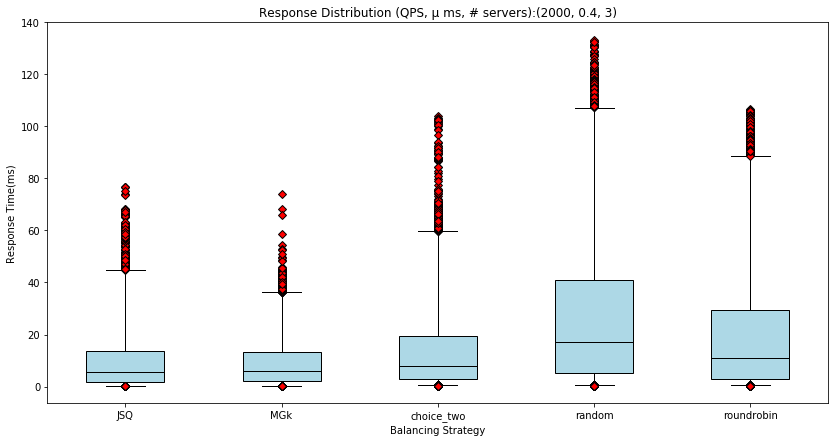

In [4]:
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


def color_bplot(bp, edge_color, fill_color):
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for box in bp['boxes']:
        box.set_facecolor(fill_color)  

fig1, ax = plt.subplots(figsize=(14,7))

diamond = dict(markerfacecolor='r', marker='D')

data = [lbs[i] for i in types]
bplot1 = ax.boxplot(data,whis=[1,99],showfliers=True,flierprops=diamond, labels=types, patch_artist=True)
color_bplot(bplot1, 'black', 'lightblue')

plt.title('Response Distribution (QPS, μ ms, # servers):({0}, {1}, {2})'.format(
    QPS, AVG_RESPONSE_MS, SERVERS)
)
plt.xlabel('Balancing Strategy')
plt.ylabel('Response Time(ms)')
plt.show()